In [1]:
%load_ext autoreload
%autoreload 2a

import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

importlib.reload(lcwgsus)

/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

# Currently working on: IMPUTATION 

In [2]:
mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_hc_snps_gw/"

sample_linker='data/metadata/sample_linker.csv'
sample_linker = pd.read_csv(sample_linker)

# chip, lc, af = lcwgsus.imputation_calculation_preprocess(chip_vcf, quilt_vcf, af_txt, save_vcfs = False)

In [35]:
quilt_vcf = imp_dir + 'vcf/all_samples/lc_vcf/lc.chr22.vcf.gz'
chip_vcf = imp_dir + 'vcf/all_samples/hc_vcf/hc.chr22.vcf.gz'
af = "data/gnomAD_MAFs/afr/gnomAD_MAF_afr_chr22.txt"

# chip, lc, af = lcwgsus.imputation_calculation_preprocess(chip_vcf, quilt_vcf, af_txt)

In [56]:
chromosomes = [str(i) for i in range(1,23)]
h_lst = ["results/imputation_metrics/lc_chip/by_variant/lc.chip.typed.chr" + i + ".h.impacc.tsv" for i in chromosomes]
v_lst = ["results/imputation_metrics/lc_chip/by_sample/lc.chip.typed.chr" + i + ".v.impacc.tsv" for i in chromosomes]

h_dfs = [pd.read_csv(i, sep = '\t') for i in h_lst]
v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]

h = lcwgsus.average_impacc_by_chr(h_dfs)
v = lcwgsus.average_impacc_by_chr(v_dfs)

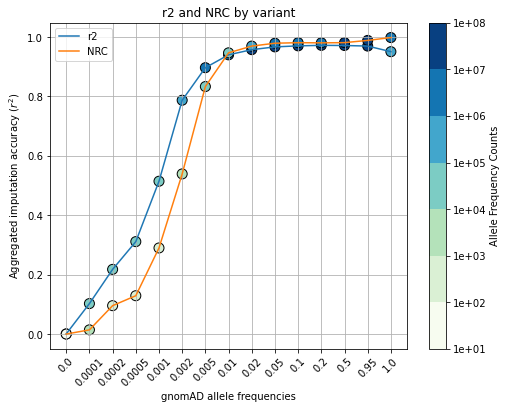

In [191]:
dfs = [h[['AF', 'r2', 'r2_AC']], h[['AF', 'NRC', 'NRC_AC']]]
lcwgsus.plot_imputation_accuracy(dfs, title = 'r2 and NRC by variant')

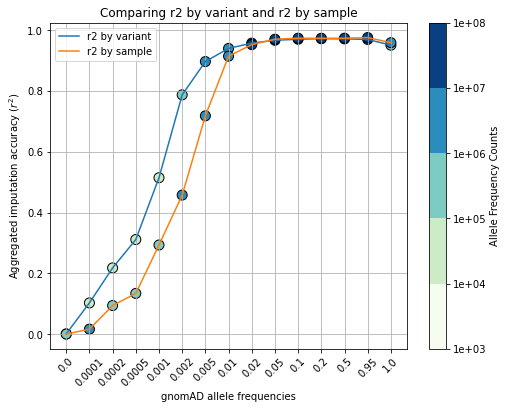

In [194]:
dfs = [h[['AF', 'r2', 'r2_AC']], v[['AF', 'r2', 'r2_AC']]]
plot_imputation_accuracy(dfs, labels = ['r2 by variant', 'r2 by sample'], title = 'Comparing r2 by variant and r2 by sample')

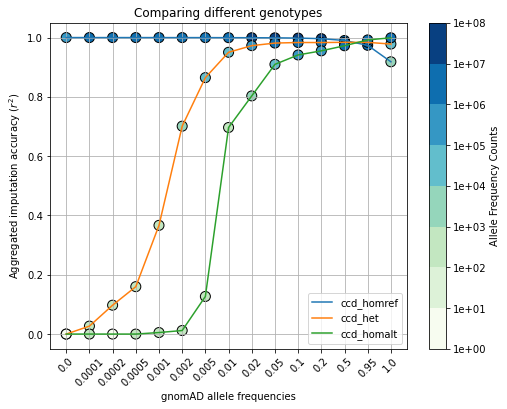

In [196]:
dfs = [h[['AF', 'ccd_homref', 'ccd_homref_AC']], h[['AF', 'ccd_het', 'ccd_het_AC']], h[['AF', 'ccd_homalt', 'ccd_homalt_AC']]]
plot_imputation_accuracy(dfs, title = 'Comparing different genotypes')

---
# For Gavin plot

In [10]:
c = 11
pos = 5227002

site = 'chr' + str(c) + ':' + str(pos) + '-' + str(pos)

lc_chr11 = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/oneKG/quilt.chr11.vcf.gz"
chip_imp_chr11 = "/well/band/users/rbx225/GAMCC/results/chip/imputed/topmed/emp_vcf/chr11.empiricalDose.vcf.gz"

vcfs = [lc_chr11, chip_imp_chr11]

df_ary = []
common_cols = [
    'chr', 'pos', 'ID', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT'
]
for i in vcfs:
    command = "tabix" + " " + i + " " + site + " | tail -n 1"
    data = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\t')
    command = "bcftools query -l" + " " + i
    name = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
    col = common_cols + name
    df = pd.DataFrame([data], columns=col)
    df_ary.append(df)

In [11]:
sample_linker = 'data/metadata/sample_linker.csv'
mini = False

lc, chip = tuple(df_ary)

sample_linker = pd.read_table(sample_linker, sep=',')
if not mini:
    sample_linker = sample_linker[~sample_linker['Sample_Name'].str.
                                  contains('mini')]
    lc_samples = lc.columns[lc.columns.str.contains(lc_sample_prefix)
                            & ~lc.columns.str.contains('mini')]
else:
    sample_linker = sample_linker[
        sample_linker['Sample_Name'].str.contains('mini')]
    lc_samples = lc.columns[lc.columns.str.contains(lc_sample_prefix)
                            & lc.columns.str.contains('mini')]
rename_map = dict(
    zip(sample_linker['Sample_Name'], sample_linker['Chip_Name']))

vcf_cols = [
    'chr', 'pos', 'ID', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT'
]

chip_samples = chip.columns[chip.columns.str.contains(chip_sample_prefix)]
lc_to_retain = lcwgsus.find_matching_samples(lc_samples, chip_samples, rename_map)
lc = lc[vcf_cols + lc_to_retain]

chip_order = []
for i in lc_to_retain:
    chip_order.append(rename_map[i])
chip = chip[vcf_cols + chip_order]

lc = lc.apply(lcwgsus.extract_GP, axis=1)
chip = chip.apply(lcwgsus.extract_LDS, axis=1)    

lc = lc.drop(columns=vcf_cols)
chip = chip.drop(columns=vcf_cols)

In [13]:
df = lc.copy()
df['genotype'] = ['0/0']

# Move the new column to the first position
cols = df.columns.tolist()  # Get the list of column names
cols = ['genotype'] + [col for col in cols if col != 'genotype']  # Move 'New' to the first position
df = df[cols] 
df.loc[2] = 

,genotype,GM1002,GM1005,GM101,GM1019,GM1047,GM1075,GM1078,GM1109,GM1110,...,GM777,GM781,GM804,GM805,GM845,GM855,GM866,GM872,GM877,GM94
0,0/0,"0.998,0.002,0","0.803,0.197,0","0.998,0.002,0","0.998,0.002,0","0.998,0.002,0","0.001,0.998,0.001","0.998,0.002,0","0.998,0.002,0","0,0.002,0.998",...,"0.998,0.002,0","0.998,0.002,0","0.998,0.002,0","0.998,0.002,0","0.998,0.002,0","0.998,0.002,0","0.996,0.004,0","0.998,0.002,0","0.998,0.002,0","0,0.002,0.998"


In [19]:
df = lc.copy()
df = df.apply(lambda x: x.str.split(',').explode()).reset_index(drop = True)
# df['genotype'] = ['0/0', '0/1', '1/1']

# cols = df.columns.tolist() 
# cols = ['genotype'] + [col for col in cols if col != 'genotype']  
# df = df[cols] 
df

,GM1002,GM1005,GM101,GM1019,GM1047,GM1075,GM1078,GM1109,GM1110,GM1114,...,GM777,GM781,GM804,GM805,GM845,GM855,GM866,GM872,GM877,GM94
0,0.998,0.803,0.998,0.998,0.998,0.001,0.998,0.998,0,0.998,...,0.998,0.998,0.998,0.998,0.998,0.998,0.996,0.998,0.998,0
1,0.002,0.197,0.002,0.002,0.002,0.998,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.004,0.002,0.002,0.002
2,0,0,0,0,0,0.001,0,0,0.998,0,...,0,0,0,0,0,0,0,0,0,0.998


<AxesSubplot:xlabel='GT', ylabel='GP'>

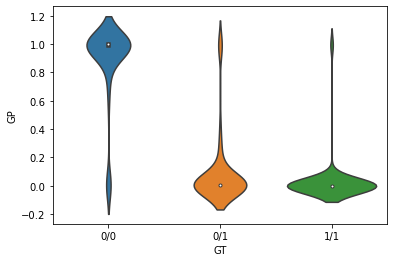

In [45]:
x = df.stack().reset_index(drop=True)
y = pd.Series(['0/0'] * len(df.columns) + ['0/1'] * len(df.columns) + ['1/1'] * len(df.columns))
res = pd.concat([x,y], ignore_index = True, axis = 1)
res.columns = ['GP', 'GT']
res['GP'] = res['GP'].astype(float)
sns.violinplot(data=res, x = 'GT', y = 'GP')

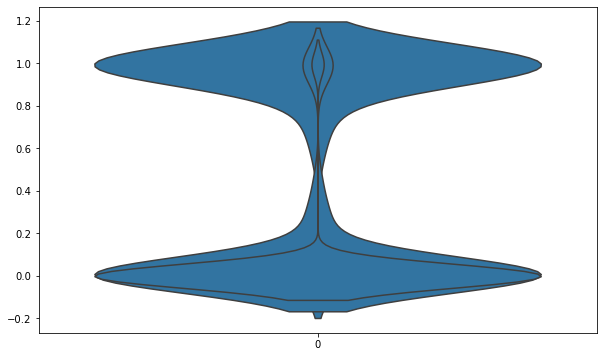

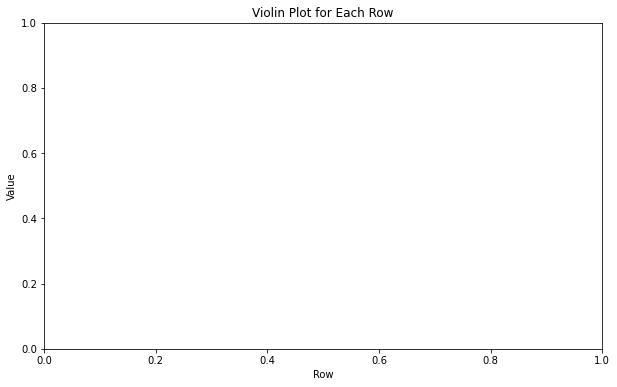

In [34]:
plt.figure(figsize=(10, 6))
for i in range(len(df)):
    sns.violinplot(data=df.loc[i], label=f'Row {i}', inner=None)
plt.figure(figsize=(10, 6))
plt.ylabel('Value')
plt.xlabel('Row')
plt.title('Violin Plot for Each Row')
plt.show()

In [8]:
pd.concat([lc,chip], ignore_index=True)

,chr,pos,ref,alt,GM1002,GM1005,GM101,GM1019,GM1047,GM1075,...,GAM190758,GAM319842,GAM314029,GAM786925,GAM340189,GAM382597,GAM620314,GAM975418,GAM270698,GAM592361
0,chr11,5227002,T,A,"0.998,0.002,0","0.803,0.197,0","0.998,0.002,0","0.998,0.002,0","0.998,0.002,0","0.001,0.998,0.001",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr11,5227002,T,A,NaN,NaN,NaN,NaN,NaN,NaN,...,"1.000,0.000,0.000","0.998,0.002,0.000","0.997,0.003,0.000","1.000,0.000,0.000","0.981,0.019,0.000","1.000,0.000,0.000","0.999,0.001,0.000","0.999,0.001,0.000","1.000,0.000,0.000","0.000,0.000,1.000"
